In [1]:
import numpy as np
import pandas as pd 

!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

!pip install folium
import folium
from folium.plugins import HeatMap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
filename = 'kc_house_data.csv'

In [3]:
#https://www.kaggle.com/harlfoxem/housesalesprediction

#Don't think too much about the getDataset method. It is used for convenience
def getDataset(filename, **kwargs):
    url = f'https://github.com/IvanReznikov/mdx-msc-data-science/raw/main/datasets/{filename}'
    try:
        import os
        if filename not in os.listdir():
            !pip install wget
            import wget
            downloaded_filename = wget.download(url)
            print(f'{downloaded_filename} file downloaded')
        else:
            print(f'{filename} already exists')
        return pd.read_csv(filename, **kwargs)
        
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

In [4]:
df = getDataset(filename)
df.head()

kc_house_data.csv already exists


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

### Function to Calculate the Adjusted

The R-squared increases when the number of features increase. Because of this, sometimes a more robust evaluator is preferred to compare the performance between different models. This evaluater is called adjusted R-squared and it only increases, if the addition of the variable reduces the MSE. The definition of the adjusted $R^{2}$ is:

$\bar{R^{2}}=R^{2}-\frac{k-1}{n-k}(1-R^{2})$

where $n$ is the number of observations and $k$ is the number of parameters. 

In [6]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

## Data checking

In [7]:
#checking if any value is missing
print(df.isnull().any())

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool


In [8]:
#checking for categorical data
print(df.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


## Simple Linear Regression

When we model a linear relationship between a response and **just one** explanatory variable, that is **simple linear regression**. 

We want to predict house prices. For a simple model we need to select a feature. 

*If we to pick just one feature, what column would you choose for price prediction?*

<AxesSubplot:>

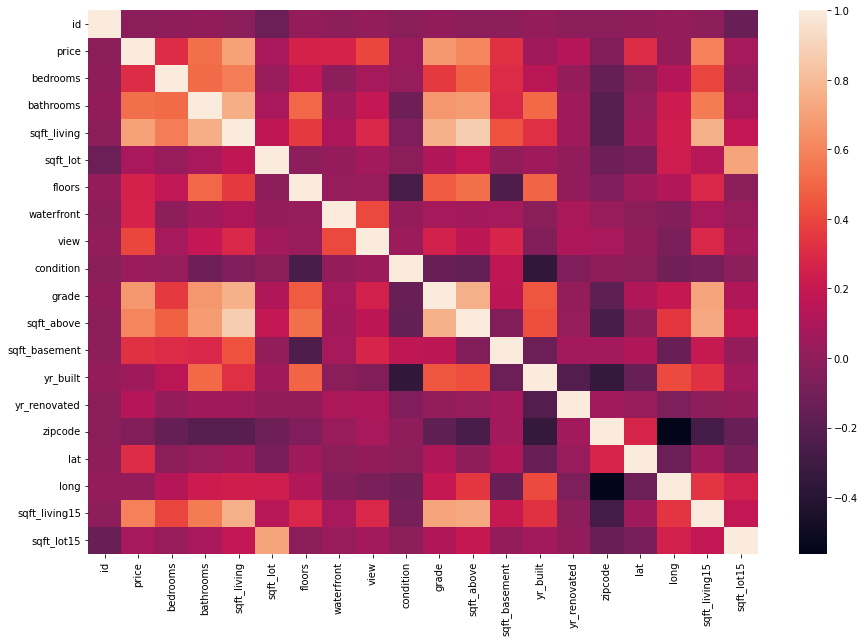

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr())

I'd say living area (sqft) seems the most important feature. But if we take a look on the correlation matrix, it seems ```sqft_lot``` feature is more import. Let's have a closer look to the attributes with the most potential: ```sqft_lot```,```sqft_above```,```sqft_living```,```bedrooms```

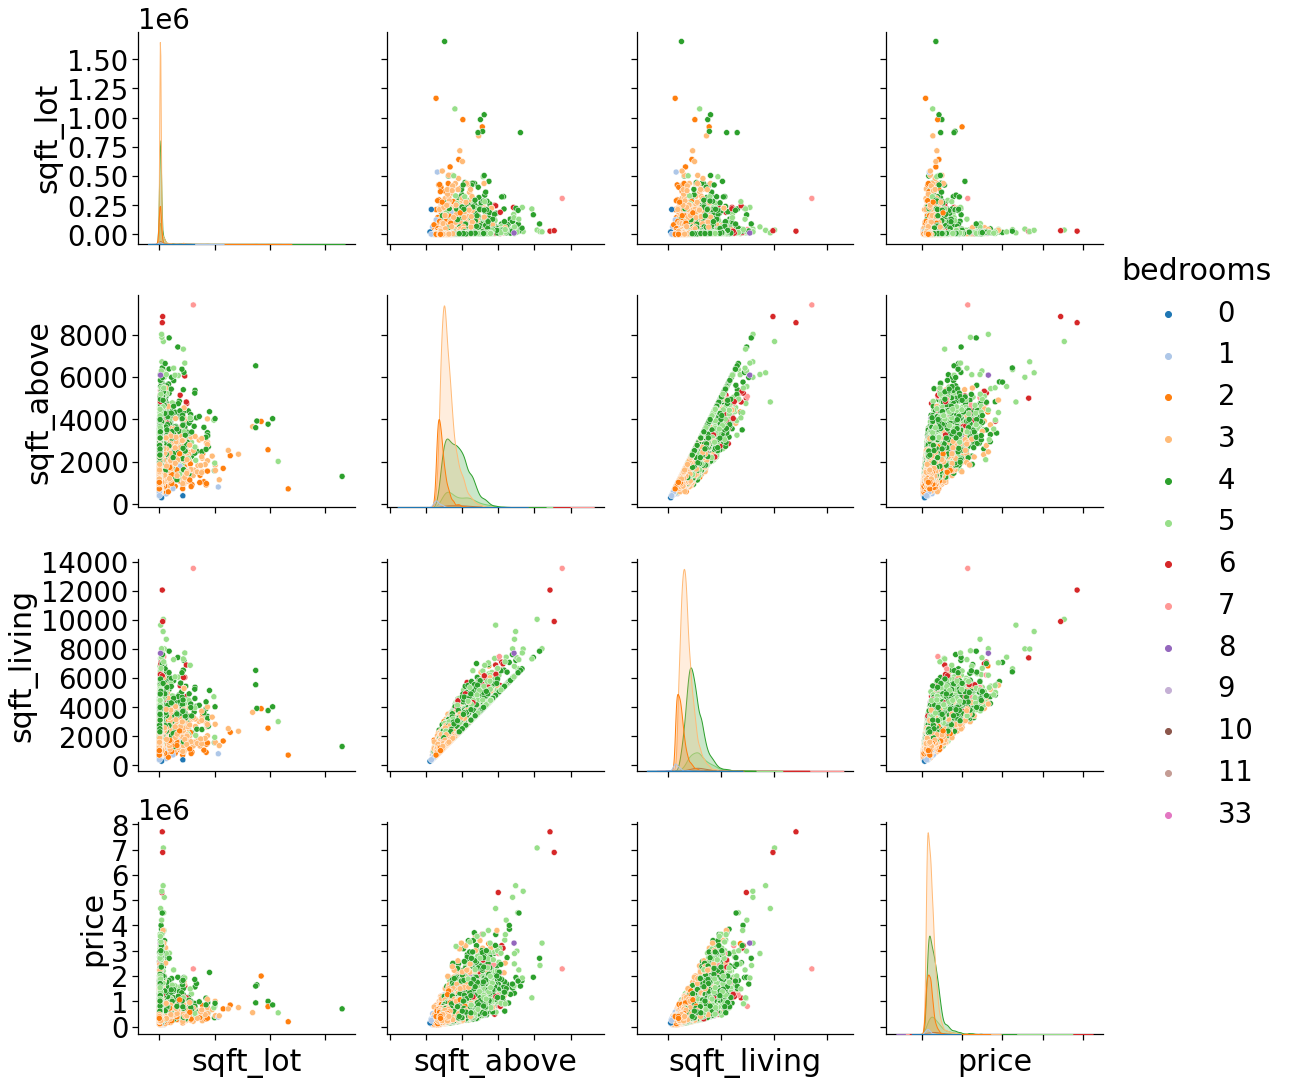

In [10]:
#understanding the distribution with seaborn
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['sqft_lot','sqft_above','sqft_living','price','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=4)
g.set(xticklabels=[]);

I personally see ```sqft_living```, as the feature to go with for simple linear regression

In [11]:
#splitting train/test

feature_name = 'sqft_living'

train_data,test_data = train_test_split(df,train_size = 0.8,random_state=42)
X_train = np.array(train_data[feature_name], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
X_test = np.array(test_data[feature_name], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

In [12]:
#linear regression in action

lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [13]:
#scoring our prediction

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,
                                  df[[feature_name]],
                                  df['price'],
                                  cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmsesm,rtrsm,'-',rtesm,'-',cv]
evaluation

Average Price for Test Data: 549367.444
Intercept: -41999.18603993731
Coefficient: [279.55477932]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


Since we have just two dimensions at the simple regression, it is easy to draw it. The below chart determines the result of the simple regression. It does not look like a perfect fit but when we work with real world datasets, having a perfect fit is not easy.

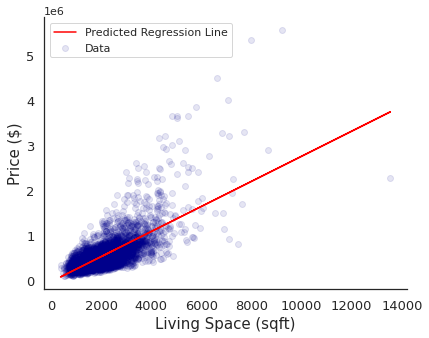

In [14]:
sns.set(style="white", font_scale=1)

plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='darkblue',label="Data", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Living Space (sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Data Exploring

As the number of features isn't that large, we can plot most of them and find useful analytical results.

Drawing charts and examining data before applying a model is good practice. We may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. 

We'll start with the histograms of dataframe.

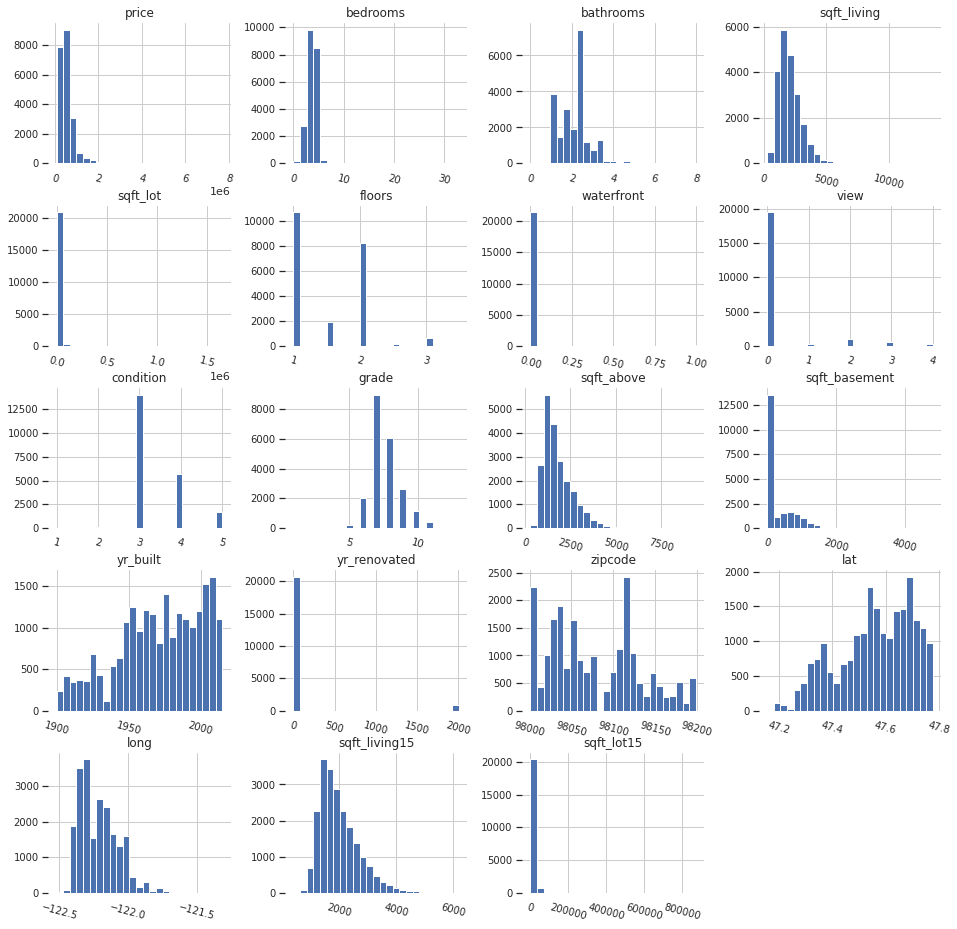

In [15]:
df_hist = df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]
h = df_hist.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

### Bedrooms, Floors, Bathrooms/Bedrooms

For not-continuous numerical data (```bedrooms```, ```floors```, ```bathrooms/bedrooms```), a good starting point is to look into boxplots. 

In [16]:
sns.set(style="whitegrid", font_scale=1)

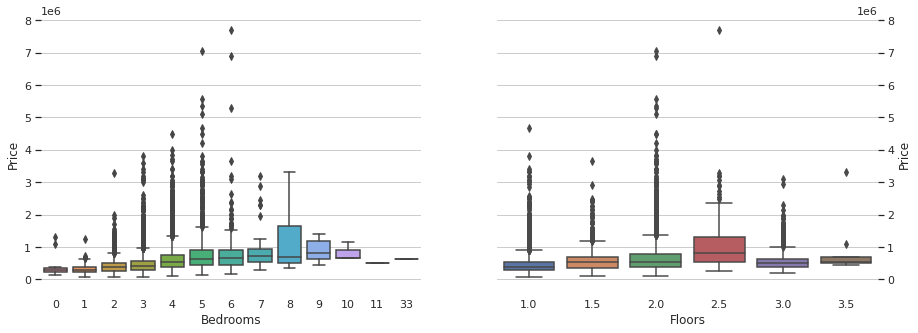

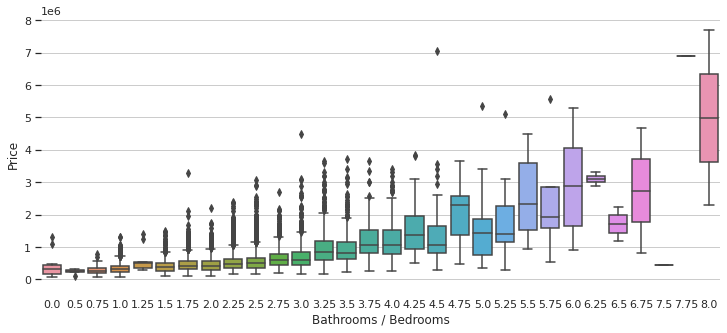

In [17]:
#plot1
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['floors'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

#plot2
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

From the below charts, it can be seen that there are very few houses which have some features or price appears far from others (11/33 bedrooms, price > 6000000).
In the real data sets there will always be some outliers like some luxury house prices in this dataset. 
Let's keep this data for now.

### Grade, Waterfront, View

There is definite dependency between price and described features. Let's visualize more columns. When we look at the below boxplots, ```grade``` and ```waterfront``` effect price obviously. On the other hand, ```view``` seem to effect less but it also has an effect on price. 

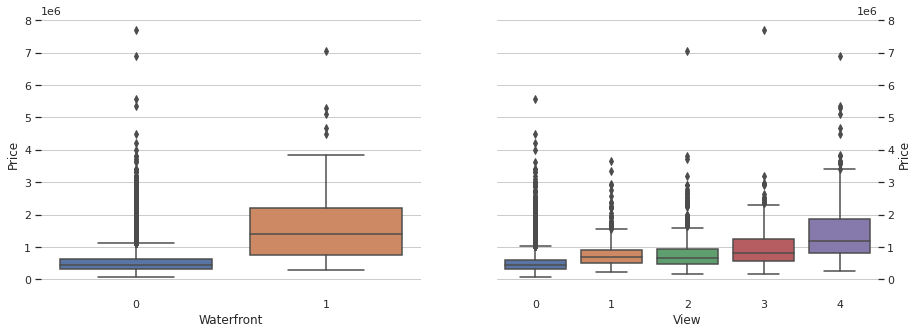

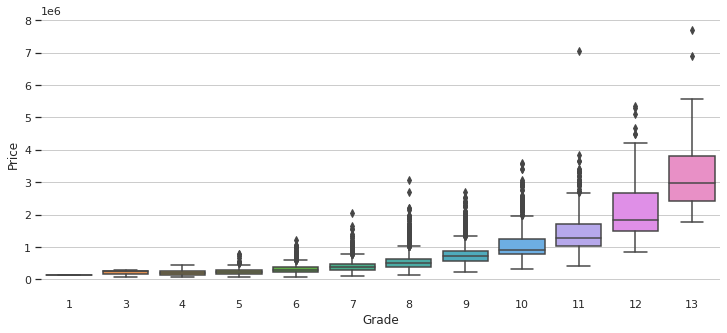

In [18]:
#plot1
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['waterfront'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['view'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

#plot2
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=df['grade'],y=df['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price');

### Geo: Latitude and Longtitude

In this dataset, we have latitude and longtitude information for the houses. By using *lat* and *long* columns, I displayed the below heat map which is very useful for the people who does not know Seattle well. Also, if you select a spesific zip code, you may just see the heat map of this zip code's neighborhood.

In [19]:
# find the row of the house which has the highest price
maxpr=df.loc[df['price'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()
df_copy['count'] = 1
basemap = generateBaseMap()

# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)

# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)

# add heatmap
HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## Correlation Among Explanatory Variables

Too many features in a model is not always good.
It might cause overfitting. *Why?* 


Another important thing is correlation among variables. **If there is very high correlation between two features, keeping both of them is not a good idea. Most of the time it leads to overfitting**. 

Let's take another look on the correlation matrix. This time, we'll go more deaper

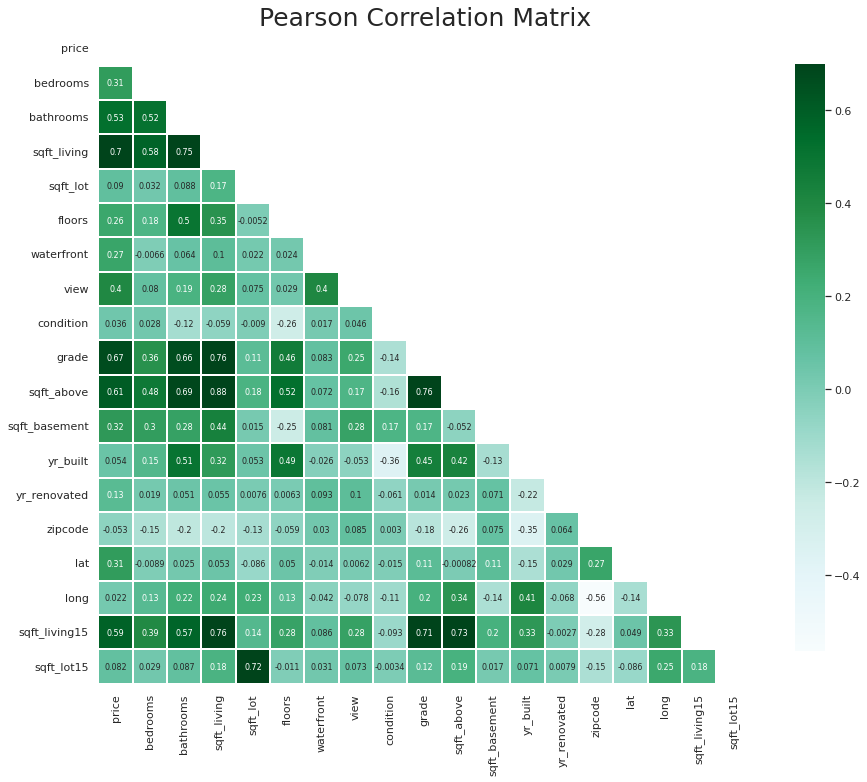

In [20]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

*What features would you exclude?*

## Data Preprocessing

A preprocessing on data might improve the model accuracy and make the model more reliable. It does not always have to improve our results but when we are conscious of the features and use a proper input, we might reach some outcomes easier.

In order to not corrupt the inital dataframe, let's create a new one:

In [21]:
df_dm=df.copy()
df_dm.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


###  Binning

Data binning is a preprocessing technique used to reduce the effects of minor observation errors. 

For exampe, we can apply binning to *yr_built* and *yr_renovated*. 

We can also add the ages and renovation ages of the houses when they were sold. 

Last, we'll partion these columns to intervals.

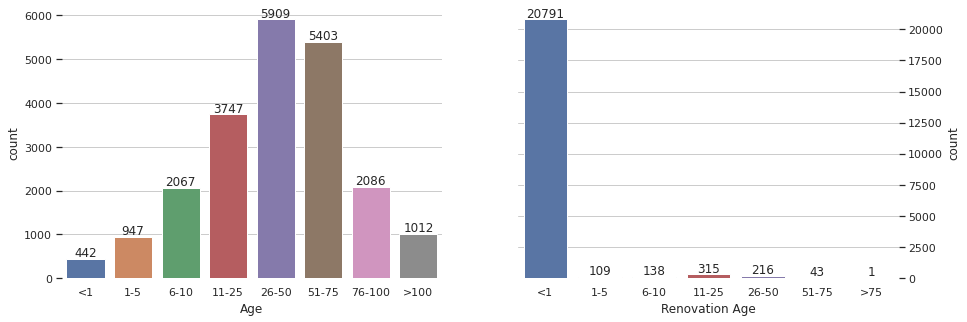

In [22]:
# just take the year from the date column
df_dm['sales_yr']=df_dm['date'].astype(str).str[:4]

# add the age of the buildings when the houses were sold as a new column
df_dm['age']=df_dm['sales_yr'].astype(int)-df_dm['yr_built']
# add the age of the renovation when the houses were sold as a new column
df_dm['age_rnv']=0
df_dm['age_rnv']=df_dm['sales_yr'][df_dm['yr_renovated']!=0].astype(int)-df_dm['yr_renovated'][df_dm['yr_renovated']!=0]
df_dm['age_rnv'][df_dm['age_rnv'].isnull()]=0

# partition the age into bins
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df_dm['age_binned'] = pd.cut(df_dm['age'], bins=bins, labels=labels)
# partition the age_rnv into bins
bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
df_dm['age_rnv_binned'] = pd.cut(df_dm['age_rnv'], bins=bins, labels=labels)

# histograms for the binned columns
f, axes = plt.subplots(1, 2,figsize=(15,5))
p1=sns.countplot(df_dm['age_binned'],ax=axes[0])
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")   
p2=sns.countplot(df_dm['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
for p in p2.patches:
    height = p.get_height()
    p2.text(p.get_x()+p.get_width()/2,height + 200,height,ha="center")
    
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');

# transform the factor values to be able to use in the model
df_dm = pd.get_dummies(df_dm, columns=['age_binned','age_rnv_binned'])

## Multiple Regression

Our simple linear regression was found to be a poor fit. 

In order to improve this model we can add more features. In this case, it'll be **multiple linear regression**.

### Multiple Regression - 1

Our first set of features will include ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','zipcode']

As in the simple regression, we'll print coefficients which the model uses for the predictions. However, this time we must use the below definition for our predictions, if we want to make calculations manually.

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+...+\theta_{n}x_{n}$$

In [24]:
train_data_dm,test_data_dm = train_test_split(df_dm,train_size = 0.8,random_state=3)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','zipcode']
complex_model_1 = linear_model.LinearRegression()
complex_model_1.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_1.intercept_))
print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_1.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_1.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_1.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_1.score(test_data_dm[features],test_data['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_1,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-1','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -57221293.13485921
Coefficients: [-5.68950279e+04  1.13310062e+04  3.18389287e+02 -2.90807628e-01
 -5.79609821e+03  5.84022824e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


### Multiple Regression - 2

In addition to the previous subsection, we'll added more features to our ***features*** list. Let's see if the'll improve our forecast.

In [25]:
features += ['waterfront','view', 'grade','age_binned_<1', 'age_binned_1-5', 'age_binned_6-10',
             'age_binned_11-25', 'age_binned_26-50', 'age_binned_51-75','age_binned_76-100', 'age_binned_>100']
complex_model_2 = linear_model.LinearRegression()
complex_model_2.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_2.intercept_))
print('Coefficients: {}'.format(complex_model_2.coef_))

pred = complex_model_2.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_2.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_2.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_2.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_2.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_2,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-2','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 14932064.456708413
Coefficients: [-3.74523328e+04  4.83495326e+04  1.71684976e+02 -2.31081061e-01
  1.03590806e+04 -1.60046391e+02  5.56285921e+05  4.78399848e+04
  1.24143045e+05 -8.88123227e+04 -1.05756567e+05 -1.04723750e+05
 -1.35898725e+05 -5.37336956e+04  8.41048129e+04  1.84153081e+05
  2.20667166e+05]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


### Multiple Regression - 3

Let's take a look at the results with the raw features we had at the beginning. It'll be a good comparison.  

In [26]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_3 = linear_model.LinearRegression()
complex_model_3.fit(train_data[features],train_data['price'])

print('Intercept: {}'.format(complex_model_3.intercept_))
print('Coefficients: {}'.format(complex_model_3.coef_))

pred = complex_model_3.predict(test_data[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_3.score(train_data[features],train_data['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_3.score(train_data[features],train_data['price']),train_data.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_3.score(test_data[features],test_data['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_3.score(test_data[features],test_data['price']),test_data.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_3,df[features],df['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-3','all features, no preprocessing',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 6643873.527883975
Coefficients: [-3.43354187e+04  4.45645289e+04  1.09015817e+02  8.88473539e-02
  7.00312952e+03  5.62413070e+05  5.36411070e+04  2.45267101e+04
  9.45678917e+04  7.00227409e+01  3.89930758e+01 -2.68076890e+03
  2.04156328e+01 -5.52253038e+02  5.95968122e+05 -1.94585724e+05
  2.12143306e+01 -3.25831873e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Multiple Regression-3,"all features, no preprocessing",212539.517,0.699,0.699,0.701,0.7,0.695
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


### Multiple Regression - 4

In addition, we can also add the data after preprocessing step.

In [27]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_4 = linear_model.LinearRegression()
complex_model_4.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_4.intercept_))
print('Coefficients: {}'.format(complex_model_4.coef_))

pred = complex_model_4.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_4.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_4.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_4.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_4.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_4,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-4','all features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 8748434.764269525
Coefficients: [-3.33491904e+04  3.76549641e+04  1.10716193e+02  1.22826592e-01
 -1.26725956e+04  5.69817402e+05  5.41386091e+04  3.17275550e+04
  9.52300581e+04  7.05366738e+01  4.01795152e+01 -4.46861874e+04
 -5.43838963e+04 -7.11287025e+04 -8.93583274e+04 -5.92594439e+04
  3.70943651e+04  1.22837694e+05  1.58884499e+05 -1.97812401e+04
  9.43034022e+04  8.74164248e+04  4.14131931e+04 -1.50309593e+04
 -1.06990366e+05 -8.13304552e+04 -6.50061210e+02  6.03335811e+05
 -2.10031732e+05  2.42386074e+01 -3.08651553e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",212539.517,0.699,0.699,0.701,0.7,0.695
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


## Regularization


**Regularization** is designed to address the problem of overfitting and undefitting.

When we apply regularization, all the features are kept and the model adjusts $\theta_{j}$. This especially works when we have a lot of slightly useful features. There are two widely used regularization types (Ridge and Lasso Regressions) and in this section, we'll use both.

**When to use ridge vs lasso regression:**
*  Many small/medium sized effects: use *ridge*.
*  Only a few variables with medium/large effect: use *lasso*.


### Ridge Regression

Ridge regression is called **L2 regularization** and by adding a penalty, we obtain the below equation

$$RSS_{RIDGE} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}\theta^{2}_{j}$$

By changing the $\alpha$ value, we can control the amount of the regularization. When we increase $\alpha$, regularization increases and the opposite is valid too. As a result of this, I selected different $\alpha$ values and used a linear regression without regularization in order to observe the differences easily.

In [28]:
features = features

complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_R.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_R.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_R.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
5,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",212539.517,0.699,0.699,0.701,0.7,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
7,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512
0,Simple Linear Regression,-,276559.175,0.492,-,0.494,-,0.491


### Lasso Regression

Lasso regression is called **L1 regularization** and it is defined as

$$RSS_{LASSO} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}|\theta_{j}|$$

The main difference between ridge and lasso is the penalty but $\alpha$ works the same way.   

In [29]:
features = features

complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_L.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_L.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_L.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
5,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
8,Lasso Regression,"alpha=1, all features",191880.918,0.701,0.7,0.713,0.711,0.698
9,Lasso Regression,"alpha=100, all features",192060.144,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",212539.517,0.699,0.699,0.701,0.7,0.695
10,Lasso Regression,"alpha=1000, all features",193587.943,0.697,0.697,0.708,0.706,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
7,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512


## Bonus: Polynomial Regression

For the linear models, the main idea is to fit a straight line to our data. However, if the data has a quadratic distribution, this time choosing a quadratic function and applying a polynomial transformation may give us better results. This time the hypothesis function is defined as

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x+\theta_{2}x^{2}+...+\theta_{n}x^{n}$$

Since there are many variations for the polynomial regression, it is prefered to show results by a new table and it can be seen from the below table that polynomial transformation improved the model fit a lot. On the other hand, while using polynomial transformation and deciding to degree, we should be very careful because it **migh cause overfitting**. Also, in the below table overfitting exists for some models. The 5-fold cross validation metrics are negative or low for these models although they have very high R-squared values for the training set.

In [31]:
POLY = False

In [32]:
if POLY:
    evaluation_poly = pd.DataFrame({'Model': [],
                                'Details':[],
                                'Root Mean Squared Error (RMSE)':[],
                                'R-squared (training)':[],
                                'Adjusted R-squared (training)':[],
                                'R-squared (test)':[],
                                'Adjusted R-squared (test)':[],
                                '5-Fold Cross Validation':[]})

    features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','yr_built','zipcode']
    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df[features])
    X_trainpoly = polyfeat.fit_transform(train_data[features])
    X_testpoly = polyfeat.fit_transform(test_data[features])
    poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

    pred1 = poly.predict(X_testpoly)
    rmsepoly1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred1)),'.3f'))
    rtrpoly1 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
    rtepoly1 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
    cv1 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=3)
    X_allpoly = polyfeat.fit_transform(df[features])
    X_trainpoly = polyfeat.fit_transform(train_data[features])
    X_testpoly = polyfeat.fit_transform(test_data[features])
    poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

    pred2 = poly.predict(X_testpoly)
    rmsepoly2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred2)),'.3f'))
    rtrpoly2 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
    rtepoly2 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
    cv2 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

    features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df[features])
    X_trainpoly = polyfeat.fit_transform(train_data[features])
    X_testpoly = polyfeat.fit_transform(test_data[features])
    poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

    pred3 = poly.predict(X_testpoly)
    rmsepoly3 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred3)),'.3f'))
    rtrpoly3 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
    rtepoly3 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
    cv3 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=3)
    X_allpoly = polyfeat.fit_transform(df[features])
    X_trainpoly = polyfeat.fit_transform(train_data[features])
    X_testpoly = polyfeat.fit_transform(test_data[features])
    poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

    pred4 = poly.predict(X_testpoly)
    rmsepoly4 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred4)),'.3f'))
    rtrpoly4 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
    rtepoly4 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
    cv4 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))


    features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df_dm[features])
    X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
    X_testpoly = polyfeat.fit_transform(test_data_dm[features])
    poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

    pred5 = poly.predict(X_testpoly)
    rmsepoly5 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred5)),'.3f'))
    rtrpoly5 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
    rtepoly5 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
    cv5 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df_dm[features])
    X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
    X_testpoly = polyfeat.fit_transform(test_data_dm[features])
    poly = linear_model.Ridge(alpha=1).fit(X_trainpoly, train_data['price'])

    pred6 = poly.predict(X_testpoly)
    rmsepoly6 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred6)),'.3f'))
    rtrpoly6 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
    rtepoly6 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
    cv6 = float(format(cross_val_score(linear_model.Ridge(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df_dm[features])
    X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
    X_testpoly = polyfeat.fit_transform(test_data_dm[features])
    poly = linear_model.Ridge(alpha=50000).fit(X_trainpoly, train_data['price'])

    pred7 = poly.predict(X_testpoly)
    rmsepoly7 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred7)),'.3f'))
    rtrpoly7 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
    rtepoly7 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
    cv7 = float(format(cross_val_score(linear_model.Ridge(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df_dm[features])
    X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
    X_testpoly = polyfeat.fit_transform(test_data_dm[features])
    poly = linear_model.Lasso(alpha=1).fit(X_trainpoly, train_data['price'])

    pred8 = poly.predict(X_testpoly)
    rmsepoly8 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred8)),'.3f'))
    rtrpoly8 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
    rtepoly8 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
    cv8 = float(format(cross_val_score(linear_model.Lasso(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

    polyfeat = PolynomialFeatures(degree=2)
    X_allpoly = polyfeat.fit_transform(df_dm[features])
    X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
    X_testpoly = polyfeat.fit_transform(test_data_dm[features])
    poly = linear_model.Lasso(alpha=50000).fit(X_trainpoly, train_data['price'])

    pred9 = poly.predict(X_testpoly)
    rmsepoly9 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred9)),'.3f'))
    rtrpoly9 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
    rtepoly9 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
    cv9 = float(format(cross_val_score(linear_model.Lasso(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

    r = evaluation_poly.shape[0]
    evaluation_poly.loc[r] = ['Polynomial Regression','degree=2, selected features, no preprocessing',rmsepoly1,rtrpoly1,'-',rtepoly1,'-',cv1]
    evaluation_poly.loc[r+1] = ['Polynomial Regression','degree=3, selected features, no preprocessing',rmsepoly2,rtrpoly2,'-',rtepoly2,'-',cv2]
    evaluation_poly.loc[r+2] = ['Polynomial Regression','degree=2, all features, no preprocessing',rmsepoly3,rtrpoly3,'-',rtepoly3,'-',cv3]
    evaluation_poly.loc[r+3] = ['Polynomial Regression','degree=3, all features, no preprocessing',rmsepoly4,rtrpoly4,'-',rtepoly4,'-',cv4]
    evaluation_poly.loc[r+4] = ['Polynomial Regression','degree=2, all features',rmsepoly5,rtrpoly5,'-',rtepoly5,'-',cv5]
    evaluation_poly.loc[r+5] = ['Polynomial Ridge Regression','alpha=1, degree=2, all features',rmsepoly6,rtrpoly6,'-',rtepoly6,'-',cv6]
    evaluation_poly.loc[r+6] = ['Polynomial Ridge Regression','alpha=50000, degree=2, all features',rmsepoly7,rtrpoly7,'-',rtepoly7,'-',cv7]
    evaluation_poly.loc[r+7] = ['Polynomial Lasso Regression','alpha=1, degree=2, all features',rmsepoly8,rtrpoly8,'-',rtepoly8,'-',cv8]
    evaluation_poly.loc[r+8] = ['Polynomial Lasso Regression','alpha=50000, degree=2, all features',rmsepoly9,rtrpoly9,'-',rtepoly9,'-',cv9]
    evaluation_poly_temp = evaluation_poly[['Model','Details','Root Mean Squared Error (RMSE)','R-squared (training)','R-squared (test)','5-Fold Cross Validation']]
    evaluation_poly_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)

## Bonus: k-NN Regression 

In [33]:
KNN = False

In [34]:
if KNN:
    features = features

    knnreg = KNeighborsRegressor(n_neighbors=15)
    knnreg.fit(train_data_dm[features],train_data_dm['price'])
    pred = knnreg.predict(test_data_dm[features])

    rmseknn1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrknn1 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
    artrknn1 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
    rteknn1 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
    arteknn1 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
    cv1 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

    knnreg = KNeighborsRegressor(n_neighbors=25)
    knnreg.fit(train_data_dm[features],train_data_dm['price'])
    pred = knnreg.predict(test_data_dm[features])

    rmseknn2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrknn2 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
    artrknn2 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
    rteknn2 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
    arteknn2 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
    cv2 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

    knnreg = KNeighborsRegressor(n_neighbors=27)
    knnreg.fit(train_data_dm[features],train_data_dm['price'])
    pred = knnreg.predict(test_data_dm[features])

    rmseknn3 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrknn3 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
    artrknn3 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
    rteknn3 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
    arteknn3 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
    cv3 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

    r = evaluation.shape[0]
    evaluation.loc[r] = ['KNN Regression','k=15, all features',rmseknn1,rtrknn1,artrknn1,rteknn1,arteknn1,cv1]
    evaluation.loc[r+1] = ['KNN Regression','k=25, all features',rmseknn2,rtrknn2,artrknn2,rteknn2,arteknn2,cv2]
    evaluation.loc[r+2] = ['KNN Regression','k=27, all features',rmseknn3,rtrknn3,artrknn3,rteknn3,arteknn3,cv3]
    evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

## Evaluation Table

In [35]:
evaluation_temp=evaluation
if POLY:
    evaluation_temp=evaluation.append(evaluation_poly)
evaluation_temp1=evaluation_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)
evaluation_temp2=evaluation_temp1.reset_index()
evaluation_f=evaluation_temp2.iloc[:,1:]
evaluation_f

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
1,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
2,Lasso Regression,"alpha=1, all features",191880.918,0.701,0.7,0.713,0.711,0.698
3,Lasso Regression,"alpha=100, all features",192060.144,0.701,0.7,0.713,0.711,0.698
4,Multiple Regression-3,"all features, no preprocessing",212539.517,0.699,0.699,0.701,0.7,0.695
5,Lasso Regression,"alpha=1000, all features",193587.943,0.697,0.697,0.708,0.706,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
7,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
8,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
9,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,-0.497,0.512


*How do you think we can increase the score of our regression models?*